In [1]:
import duckdb 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
path = "/home/etienne/projects/obsq/work/dev/data/data.duckdb"
target = 'expert_match'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
table = 'combined'
schema = 'features'
con = duckdb.connect(path)
df = con.execute(f"""SELECT* FROM {schema}.{table}""" ).df()
#df = df.drop(columns= 'geom')
con.close()

IOException: IO Error: Could not set lock on file "/home/etienne/projects/obsq/work/dev/data/data.duckdb": Conflicting lock is held in /home/etienne/.duckdb/cli/1.4.3/duckdb (PID 13431) by user etienne. See also https://duckdb.org/docs/stable/connect/concurrency

In [23]:
cols_to_remove = ['tempo_eventDate']
cols_to_remove.append(target)
cols_to_remove.append('gbifID')
cols_to_remove.append('species')

In [24]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision'  # Better for imbalanced data
}

In [25]:
#One hot encode 
codes, uniques = pd.factorize(df['species'])
df['species_encoded'] = codes
uniques

Index(['Actaea pachypoda', 'Populus deltoides', 'Rubus idaeus',
       'Persicaria maculosa', 'Alliaria petiolata', 'Frangula alnus',
       'Cypripedium acaule', 'Elaeagnus angustifolia', 'Verbascum thapsus',
       'Claytonia caroliniana',
       ...
       'Carex atlantica', 'Centaurium erythraea', 'Potamogeton illinoensis',
       'Viola renifolia', 'Dichanthelium xanthophysum', 'Alnus alnobetula',
       'Acalypha rhomboidea', 'Campanula intercedens', 'Cryptogramma stelleri',
       'Podophyllum peltatum'],
      dtype='object', length=1250)

In [26]:
X = df.drop(columns=cols_to_remove)
y = df[target]


In [27]:
X.head()

,obsv_obs_count,obsv_total_pct,obsv_expert_ids,obsv_expert_ids_pct,obsv_avg_id_time,obsv_class_count,obsv_order_count,obsv_family_count,obsv_genus_count,obsv_species_count,...,meta_pheno_repro,meta_pheno_leaves,meta_pheno_sex,meta_occurrenceRemarks,pheno_leaves_month_density,pheno_sex_month_density,pheno_repro_month_density,taxo_freq,taxo_confusability_index,species_encoded
0,3389,0.08525,38,0.01100,17.00000,5,39,97,244,352,...,1,1,0,0,0.20000,NaN,0.14400,0.05700,0,0
1,3389,0.08525,38,0.01100,17.00000,5,39,97,244,352,...,1,1,0,0,0.22900,NaN,0.05500,2.74300,24,1
2,330,0.00830,0,0.00000,6.00000,5,34,69,137,170,...,1,1,0,0,0.18900,NaN,0.76700,1.61900,24,2
3,21,0.00053,0,0.00000,25.00000,3,16,19,19,19,...,1,1,0,0,0.05300,NaN,0.12500,0.01000,0,3
4,3389,0.08525,38,0.01100,17.00000,5,39,97,244,352,...,1,1,0,0,0.09100,NaN,0.23800,0.12600,0,4


In [30]:
X.shape[0]

39895

In [28]:
#Define model params
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',  # Handle imbalance
    random_state=42,
    n_jobs=-1
)

In [33]:
#Define model params
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

In [34]:
#Fit model
model.fit(X, y)



,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsam

In [35]:
#Feature importance
importances = model.feature_importances_
    
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

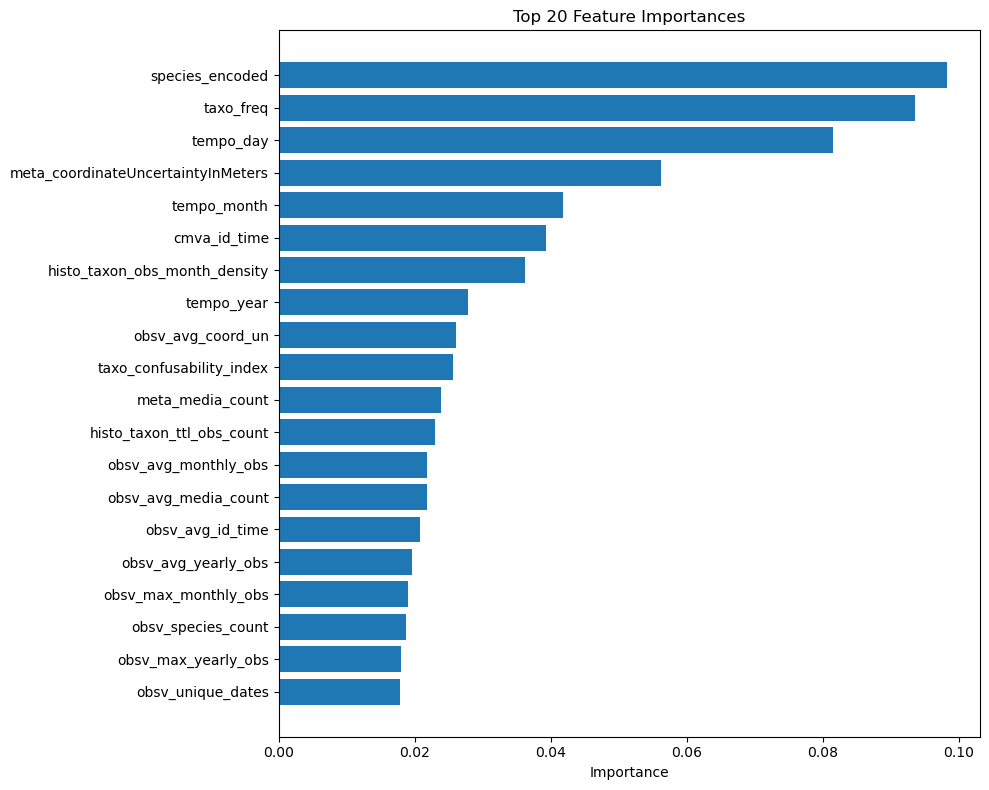


Top 10 Most Important Features:
species_encoded               : 0.0982
taxo_freq                     : 0.0936
tempo_day                     : 0.0815
meta_coordinateUncertaintyInMeters: 0.0562
tempo_month                   : 0.0418
cmva_id_time                  : 0.0393
histo_taxon_obs_month_density : 0.0362
tempo_year                    : 0.0278
obsv_avg_coord_un             : 0.0261
taxo_confusability_index      : 0.0257


In [36]:
# 7. ANALYZE FEATURE IMPORTANCE

def plot_feature_importance(importance_df, top_n=20):
    """
    Visualize which features matter most.
    
    This tells you what the model learned.
    """
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print("="*60)
    for idx, row in top_features.head(10).iterrows():
        print(f"{row['feature']:30s}: {row['importance']:.4f}")


plot_feature_importance(feature_importance_df)